# Global (Imports, Constants, Utils etc) 



## GPU type

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr  9 23:33:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 33%   47C    P5    22W / 170W |  10852MiB / 12045MiB |     31%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Module & Goggle Drive import

In [2]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install keras_tuner
except:
  pass

In [3]:
import os
import sys
import tensorflow as tf
import tensorflow.keras as keras
import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import trange, tqdm
from pickle import (
    dump,
    load
)

from tensorflow.keras import (
    layers,
    Model,
    Sequential,
    optimizers
)
from tensorflow.keras.preprocessing.sequence import (
    pad_sequences    
)

from pprint import pprint
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer



## Constant definision

In [4]:
# If runs on google colab or not
try:
  import google.colab
  BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/drone_research"
except:
  BASE_DIR = "/home/israzex/Desktop/drone_homecoming_rl/artificial_gps"

DATA_FOLDER_NAME = "data"
DATA_FOLDER_PATH = os.path.join(BASE_DIR, DATA_FOLDER_NAME)
MODELS_FOLDER_NAME = "models"
MODELS_FOLDER_PATH = os.path.join(BASE_DIR, MODELS_FOLDER_NAME)
TUNERS_FOLDER_NAME = "tuners"
TUNERS_FOLDER_PATH = os.path.join(BASE_DIR, TUNERS_FOLDER_NAME)

INPUT_COLUMNS = ["orientation_x", "orientation_y", "orientation_z", "orientation_w"]
OUTPUT_COLUMNS = ["linear_velocity_x", "linear_velocity_y", "linear_velocity_z"]

In [5]:
def get_recordings_files():
    all_csv_files = os.listdir(DATA_FOLDER_PATH)

    # Orders the "manual" files to the end (They are more likely represent 
    # the test user). So this data should be used as test
    auto_genereted_flights = [recording_file for recording_file in all_csv_files 
                              if not recording_file.startswith("manual")]
    manual_generated_flights = [recording_file for recording_file in all_csv_files 
                              if recording_file.startswith("manual")]

    all_csv_files = []
    all_csv_files.extend(auto_genereted_flights)
    all_csv_files.extend(manual_generated_flights)

    return all_csv_files


In [6]:
# Set float 64
tf.keras.backend.set_floatx('float32')

## Utils


### Save and Load models

In [7]:
def save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "wb") as file:
        dump(model, file)

    with open(scaler_x_file_path, "wb") as file:
        dump(scaler_x, file)

    with open(scaler_y_file_path, "wb") as file:
        dump(scaler_y, file)
        
def load_model_with_scalers_binary(model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "rb") as file:
        model = load(file)

    with open(scaler_x_file_path, "rb") as file:
        scaler_x = load(file)

    with open(scaler_y_file_path, "rb") as file:
        scaler_y = load(file)

    return model, scaler_x, scaler_y

## Data Split

In [8]:
def split_data(data: np.array, train_per = 0.95, dev_per= 0.5):
    """
    Splits data into train, dev and test
    :return:
    """
    data_len = len(data)

    train, dev, test = np.split(data, [int(train_per * data_len),
                                       int((dev_per + train_per) * data_len)])

    return train, dev, test


### Shuffle dataset

In [9]:
def shuffle_data_set(x_data: np.array, y_data: np.array):
    example_amount = x_data.shape[0]
    shuffle_indexes = np.random.permutation(example_amount)
    
    x_data = x_data[shuffle_indexes]
    y_data = y_data[shuffle_indexes]

    return x_data, y_data

# Data Preprocessing

### Load data

In [10]:
def load_flight_steps_from_file(csv_name: str, input_columns: list, output_columns: list):
    """

    @param csv_name:
    @param input_columns:
    @param output_columns:
    @return:
    """
    if not csv_name.endswith("csv"):
        raise ValueError(f"File with unsupported extension, expected csv (file: {csv_name})")

    csv_path = os.path.join(DATA_FOLDER_PATH, csv_name)
    flight_df = pd.read_csv(csv_path)

    x_df = flight_df[input_columns].copy()
    y_df = flight_df[output_columns].copy()
    
    return x_df, y_df

In [11]:
def load_dataset(input_columns: list, output_columns: list):
    """
    Loads flight steps and orders it to sequences of sequence_length length.
    In order to feed it to rnn/lstm s2s model

    @param input_columns: The input columns
    @param output_columns: The outputs columns
    @return:
    """
    all_csv_files = get_recordings_files()

    # x, y data from all flight sessions
    x_sessions = []
    y_sessions = []

    for csv_name in all_csv_files:
        try:
            x_df, y_df = load_flight_steps_from_file(csv_name, input_columns, output_columns)

            x_sessions.append(x_df)
            y_sessions.append(y_df)

        except ValueError as error:
            print(str(error))

    x_df = pd.concat(x_sessions, ignore_index=True)
    y_df = pd.concat(y_sessions, ignore_index=True)

    return x_df, y_df


### Preprocess data

In [35]:
def preprocess_ann_dataset(x_df: pd.DataFrame, y_df : pd.DataFrame):
    scaler_x = MinMaxScaler((-1,1))
    scaler_y = MinMaxScaler()

    y_df = y_df.round(3)    
    
    data_x = scaler_x.fit_transform(x_df)
    data_y = y_df.to_numpy()
    data_y = scaler_y.fit_transform(data_y)

    data_x = data_x.astype(np.float32)
    data_y = data_y.astype(np.float32)

    return data_x, data_y, scaler_x, scaler_y

In [13]:
def load_preprocessed_dataset(input_columns: list, output_columns: list):
    """
    Loads the whole dataset with preprocessing

    @param input_columns: Input columns names
    @param output_columns: Output columns names
    @param sequence_length: The size of input x sequence
    @return: Loaded, preprocessed, shuffled, splitted data set
    """
    x_df, y_df = load_dataset(input_columns, output_columns)
    x_data, y_data, scaler_x, scaler_y = preprocess_ann_dataset(x_df, y_df)

    train_x, dev_x, test_x = split_data(x_data, train_per=0.9, dev_per=0.1)
    train_y, dev_y, test_y = split_data(y_data, train_per=0.9, dev_per=0.1)

    return train_x, train_y, dev_x, dev_y, scaler_x, scaler_y

# Feature Analysis

In [25]:
x_df, y_df = load_dataset(INPUT_COLUMNS, OUTPUT_COLUMNS)

## Visualization

###### Plot

All Columns plot


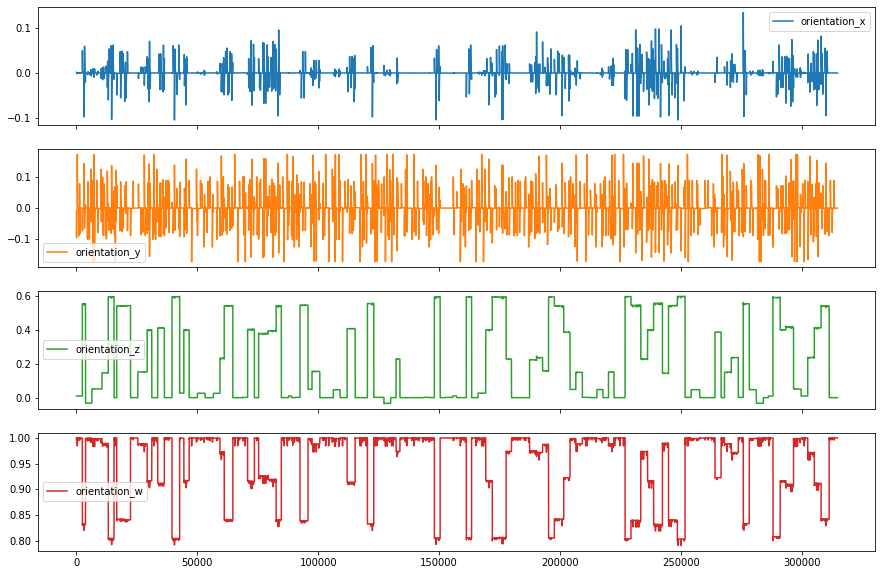

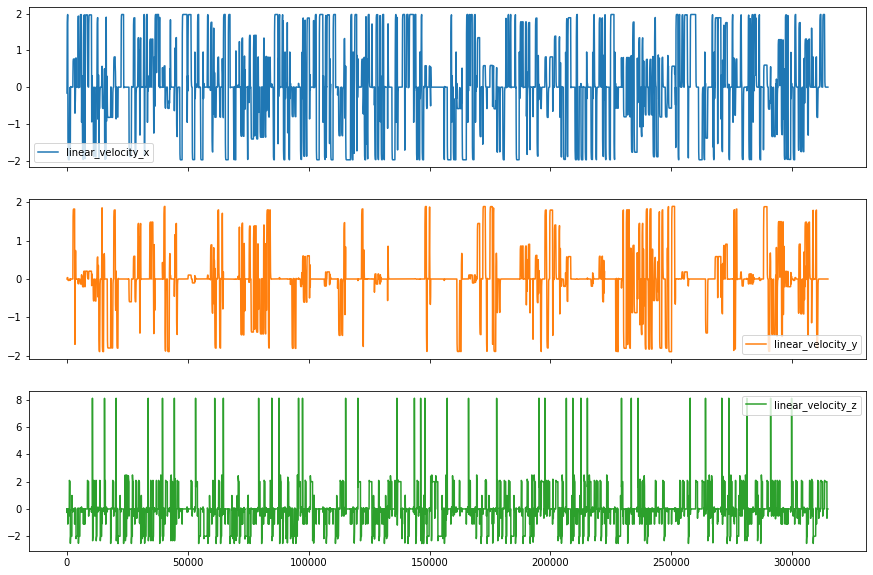

In [26]:
print("All Columns plot")
otuput = x_df.plot(subplots=True, figsize=(15,10))
otuput = y_df.plot(subplots=True, figsize=(15,10))

###### Hist

All Columns plot


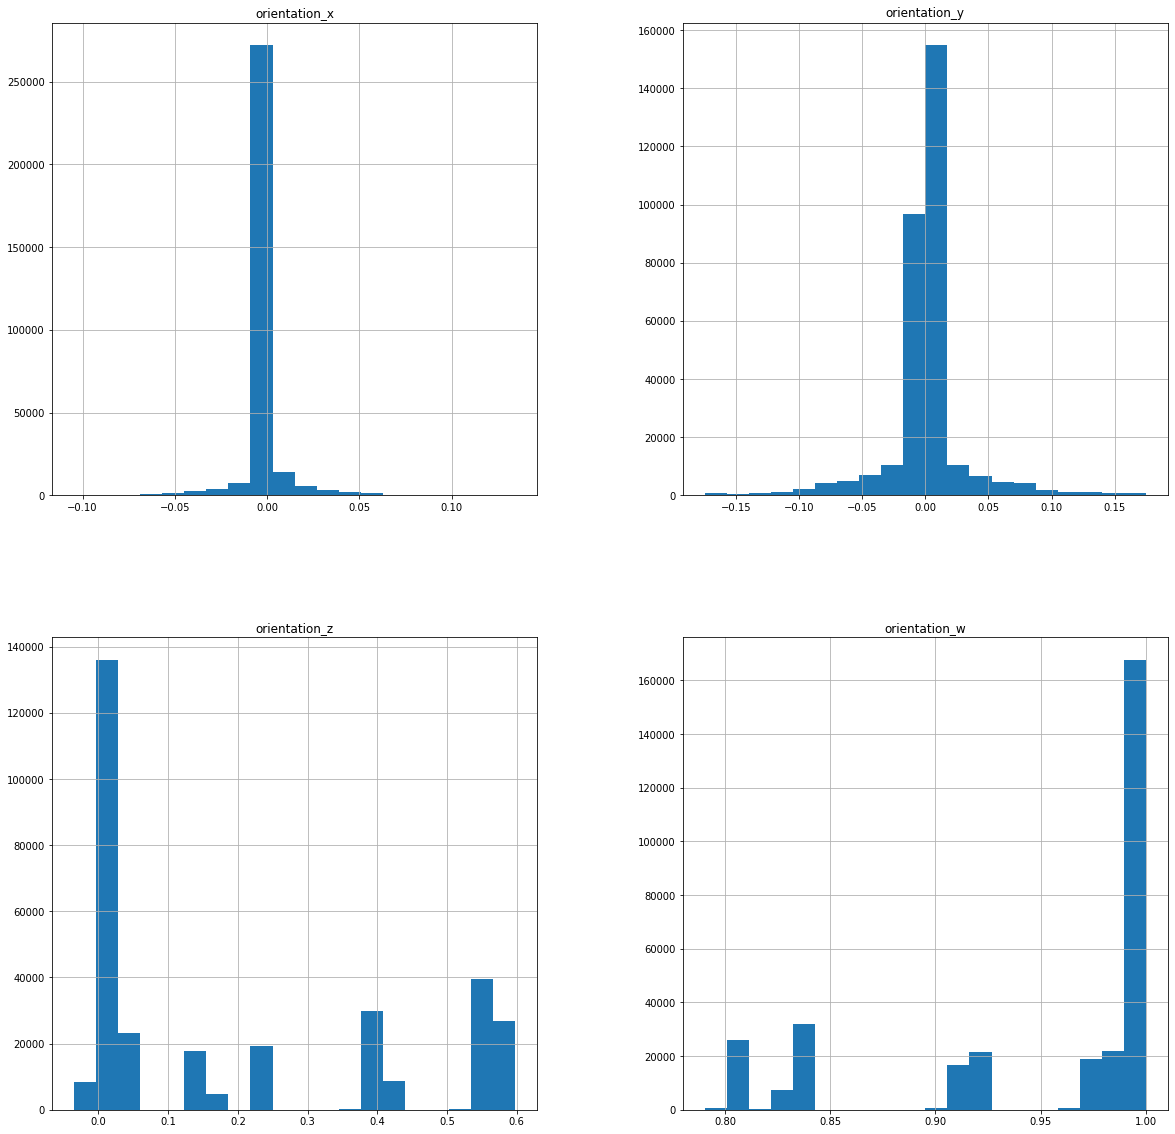

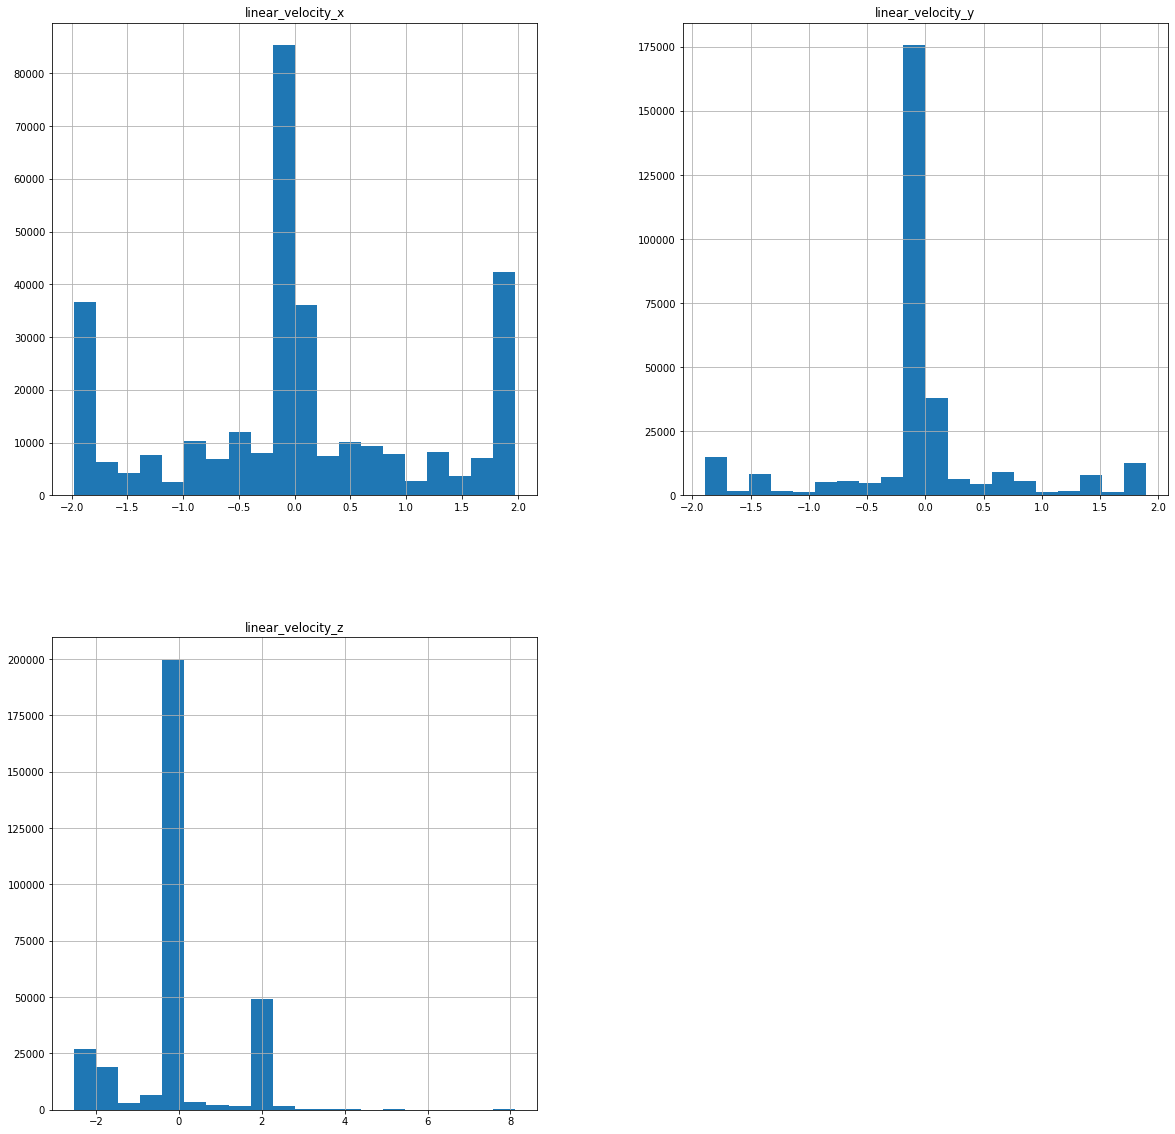

In [27]:
print("All Columns plot")
otuput = x_df.hist(figsize=(20,20), bins=20)
otuput = y_df.hist(figsize=(20,20), bins=20)

#Model creation and training 

In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [15]:
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [36]:
train_x, train_y, dev_x, dev_y, scaler_x, scaler_y = \
    load_preprocessed_dataset(INPUT_COLUMNS, OUTPUT_COLUMNS)

In [30]:
def create_ann_model(input_columns_amount: int, output_columns_amount: int) -> Model:
    """
    Creates LSTM model
    @return:
    """
    model = Sequential([
        layers.Input(shape=(input_columns_amount)),
        layers.Dense(16, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(36, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(output_columns_amount, activation="sigmoid")
    ])


    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=0.0005))
                    
    return model

def create_ann_tuned_model(input_columns_amount: int, output_columns_amount: int) -> Model:
    """
    Creates LSTM model
    @return:
    """
    model = Sequential([
        layers.Input(shape=(input_columns_amount)),
        layers.Dense(64, activation=tf.keras.layers.ELU()),
        layers.Dropout(0.2),
        layers.Dense(32, activation=tf.keras.layers.ELU()),
        layers.Dropout(0.2),
        layers.Dense(output_columns_amount, activity_regularizer=keras.regularizers.l2(1e-5)),
    ])
    

    learning_rate = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=10000,
        decay_rate=0.9)

    model.compile(loss='mean_absolute_error',
                  optimizer=optimizers.Adam(learning_rate=learning_rate))

    return model

In [37]:
model = create_ann_model(len(INPUT_COLUMNS), len(OUTPUT_COLUMNS))

history = model.fit(train_x,
          train_y,
          epochs=150,
          batch_size=512,
          validation_data=(dev_x, dev_y))

Epoch 1/150
554/554 [==============================] - 1s 791us/step - loss: 0.0495 - val_loss: 0.0451
Epoch 2/150
554/554 [==============================] - 0s 710us/step - loss: 0.0450 - val_loss: 0.0451
Epoch 3/150
554/554 [==============================] - 0s 686us/step - loss: 0.0445 - val_loss: 0.0449
Epoch 4/150
554/554 [==============================] - 0s 680us/step - loss: 0.0440 - val_loss: 0.0442
Epoch 5/150
554/554 [==============================] - 0s 679us/step - loss: 0.0432 - val_loss: 0.0426
Epoch 6/150
554/554 [==============================] - 0s 681us/step - loss: 0.0416 - val_loss: 0.0398
Epoch 7/150
554/554 [==============================] - 0s 691us/step - loss: 0.0390 - val_loss: 0.0361
Epoch 8/150
554/554 [==============================] - 0s 685us/step - loss: 0.0358 - val_loss: 0.0309
Epoch 9/150
554/554 [==============================] - 0s 690us/step - loss: 0.0322 - val_loss: 0.0266
Epoch 10/150
554/554 [==============================] - 0s 686us/step - l

In [40]:
pred_y = model.predict(dev_x)

for pred, real, pred_speed, real_speed in zip(pred_y, dev_y, scaler_y.inverse_transform(pred_y), scaler_y.inverse_transform(dev_y)):
  print(f"{pred} - {real} - {pred_speed} - {real_speed}")

Streaming output truncated to the last 5000 lines.
[0.53633255 0.51970345 0.23525679] - [0.6471927  0.83888006 0.24471582] - [ 0.14365889  0.07459725 -0.02569146] - [0.582      1.2829999  0.07499995]
[0.53833413 0.52060795 0.23544869] - [0.6484572  0.84178555 0.24480978] - [ 0.15157315  0.07802169 -0.02364871] - [0.5869999  1.2940001  0.07600007]
[0.5406903  0.52167326 0.23567498] - [0.6499747  0.84521925 0.24480978] - [ 0.16088946  0.08205497 -0.02123987] - [0.593      1.307      0.07600007]
[0.5426138  0.5225435  0.23585993] - [0.6512393  0.8481247  0.24480978] - [ 0.16849498  0.08534965 -0.01927104] - [0.5980001  1.3180001  0.07600007]
[0.54486734 0.5235635  0.23607683] - [0.6525038  0.8512942  0.24480978] - [ 0.17740545  0.08921143 -0.01696212] - [0.603      1.3299999  0.07600007]
[0.5467028  0.5243947  0.23625377] - [0.65376836 0.85393554 0.24480978] - [ 0.18466288  0.0923583  -0.01507864] - [0.6080001  1.3399999  0.07600007]
[0.5485029  0.5252104  0.23642749] - [0.6550329  0.8565

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss)
plt.plot(val_loss)

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss[50:])
plt.plot(val_loss[50:])

## Save model

In [ ]:
model_name = "ann_speed_from_orientation_9Apr_1"
save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name)

# Hyperparameters tuning

### Model Creation

In [ ]:
def create_dynamic_model(hp: kt.HyperParameters) -> Model:
    """
    Creates Sequence model dynamically
    :param hp: Hyper parameters (Initialized by a tuning algorithm)
    :return:
    """
    model = Sequential()
    model.add(layers.Input(shape=(hp.get("input_columns_amount"))))    

    dense_layers = hp.Int("dense_layers", min_value=1, max_value=4)
    for layer_id in range(dense_layers):
      layer_units = hp.Int(f"dense_{layer_id}_units", min_value=16, max_value=256, step=16)

      model.add(layers.Dense(layer_units, activation="tanh"))

      if hp.Boolean(f"dense_{layer_id}_dropout_status"):
          dropout_rate = hp.Float(f"dense_{layer_id}_dropout_rate", min_value=0, max_value=0.4, step=0.05)
          model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(hp.get("output_columns_amount")))

    learning_rate = hp.Choice("adam_learning_rate", [0.1, 0.05, 1e-2, 1e-3, 5e-3, 5e-4])

    if hp.Boolean(f"learning_rate_decay"):
        learning_rate = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=10000,
            decay_rate=0.9)

    model.compile(loss='mean_absolute_error',
                  optimizer=optimizers.Adam(learning_rate=learning_rate))

    return model



### The Tuner



In [ ]:
hp = kt.HyperParameters()
hp.Fixed("input_columns_amount", len(INPUT_SEQUENCE_COLUMNS))
hp.Fixed("output_columns_amount", len(OUTPUT_SEQUENCE_COLUMNS))

project_name = "ann_12MarDay_speed3"
tuner = kt.BayesianOptimization(
    create_dynamic_model,
    hyperparameters=hp,
    objective="val_loss",
    max_trials=1000,
    directory=TUNERS_FOLDER_PATH,
    project_name=project_name,
    executions_per_trial = 1
)

In [ ]:
tuner.get_best_hyperparameters()[0].values

{'input_columns_amount': 34,
 'output_columns_amount': 3,
 'units_left': 756,
 'dense_layers': 4,
 'dense_0_units': 192,
 'dense_0_dropout_status': False,
 'adam_learning_rate': 0.0005,
 'learning_rate_decay': False,
 'dense_0_dropout_rate': 0.4,
 'dense_1_units': 16,
 'dense_1_dropout_status': False,
 'dense_2_units': 16,
 'dense_2_dropout_status': False,
 'dense_3_units': 208,
 'dense_3_dropout_status': False,
 'dense_1_dropout_rate': 0.4,
 'dense_3_dropout_rate': 0.1,
 'dense_2_dropout_rate': 0.4}

In [ ]:
model = tuner.get_best_models()[0]
model_name = "speed_best_12Mar_10"
save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name)

INFO:tensorflow:Assets written to: ram://9003b5c1-8826-4d1b-812e-1558676a29db/assets


INFO:tensorflow:Assets written to: ram://9003b5c1-8826-4d1b-812e-1558676a29db/assets


### Truning

In [ ]:
tensorboard_dir = os.path.join(os.path.join(TUNERS_FOLDER_PATH,project_name), "tensorboard")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir, 
                                                      histogram_freq=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, baseline= 0.01)

tuner.search(train_x,
            train_y,
             validation_data=(dev_x, dev_y),
             epochs = 2000,
             batch_size=512,
             callbacks=[early_stop, tensorboard_callback])

